In [103]:
import numpy as np
import pickle
import cv2
import os
import math
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = '/content/drive/MyDrive/proj/PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

In [106]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [107]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Image loading completed

Total number of images: 1500


In [108]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  15


In [109]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [110]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [111]:
EPOCHS = 50
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [112]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = -1

model.add(Conv2D(32, (3, 3), padding = "same", input_shape = inputShape))
model.add(Activation("relu"))
# model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3, 3)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding = "same"))
model.add(Activation("relu"))
# model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3, 3)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
# model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3, 3)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_45 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 85, 85, 32)        9248      
_________________________________________________________________
activation_46 (Activation)   (None, 85, 85, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)       

In [113]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 97s 3s/step - loss: 0.6085 - accuracy: 0.0567 - val_loss: 0.3861 - val_accuracy: 0.0667
Epoch 2/50
37/37 [==============================] - 90s 2s/step - loss: 0.4570 - accuracy: 0.0724 - val_loss: 0.2911 - val_accuracy: 0.1100
Epoch 3/50
37/37 [==============================] - 92s 2s/step - loss: 0.3755 - accuracy: 0.0675 - val_loss: 0.2600 - val_accuracy: 0.0667
Epoch 4/50
37/37 [==============================] - 91s 2s/step - loss: 0.3229 - accuracy: 0.0915 - val_loss: 0.2449 - val_accuracy: 0.1200
Epoch 5/50
37/37 [==============================] - 93s 3s/step - loss: 0.3050 - accuracy: 0.0903 - val_loss: 0.2392 - val_accuracy: 0.1300
Epoch 6/50
37/37 [==============================] - 94s 3s/step - loss: 0.2870 - accuracy: 0.1121 - val_loss: 0.2411 - val_accuracy: 0.1033
Epoch 7/50
37/37 [==============================] - 91s 2s/step - loss: 0.2875 - accuracy: 0.1052 - val_loss: 0.2176 - val_accuracy: 0.2800
Epoch 8/50
37/37 [==

In [114]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
10/10 [==============================] - 6s 560ms/step - loss: 0.1279 - accuracy: 0.7000
Test Accuracy: 69.9999988079071


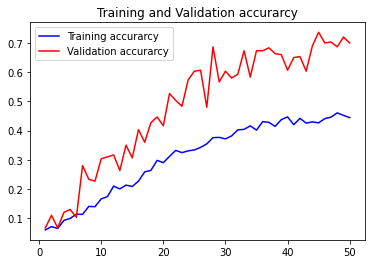

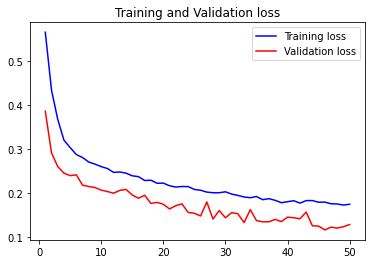

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [116]:
print("[INFO] Saving Model...")
model.save('Trained_model.h5')

[INFO] Saving Model...
